<a href="https://colab.research.google.com/github/Jaseelkt007/ML/blob/master/Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition
Human Activity Recognition (HAR) is a problem that is an active research field in pervasive computing. An HAR system has the main goal of analyzing human activities by observing and interpreting ongoing events successfully (from sensory data)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


label shape: (1214, 5)
Accelerometer data shape: (20598, 3)
act dict :{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING', 7: 'STAND_TO_SIT', 8: 'SIT_TO_STAND', 9: 'SIT_TO_LIE', 10: 'LIE_TO_SIT', 11: 'STAND_TO_LIE', 12: 'LIE_TO_STAND'}
[[    1     1     1  7496  8078]
 [    1     1     1  8356  9250]
 [    1     1     1  9657 10567]
 [    1     1     1 10750 11714]
 [    2     1     1  7624  8252]]


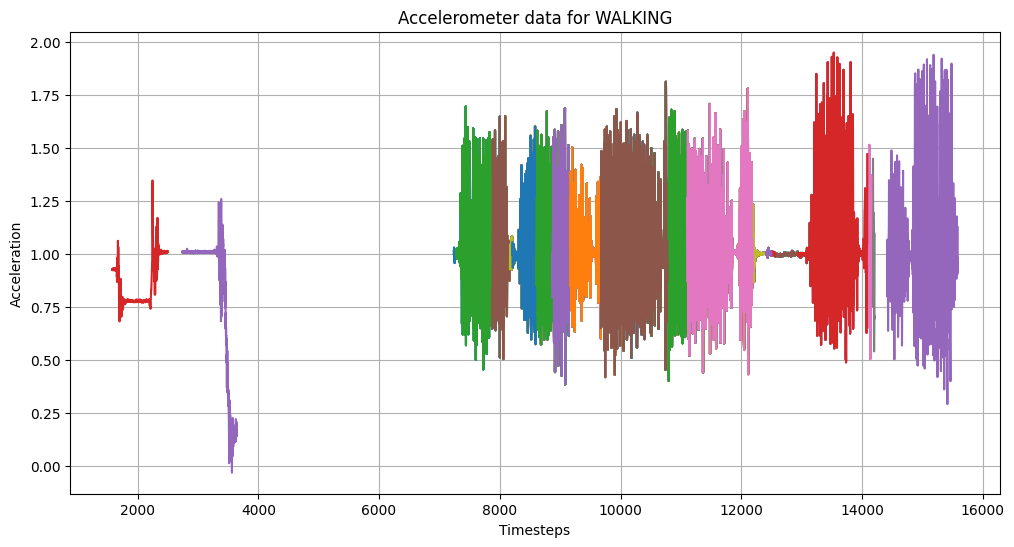

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Visualization Data

data_path = "/content/drive/MyDrive/HAR_dataset/RawData"
all_files = "/content/drive/MyDrive/HAR_dataset"

acc_file = os.path.join(data_path, "acc_exp01_user01.txt")
acc_data = np.loadtxt(acc_file)

label_files = os.path.join(data_path, "labels.txt")
labels = np.loadtxt(label_files, dtype=int)

print("label shape:", labels.shape)
print("Accelerometer data shape:", acc_data.shape)

activity_labels_path = os.path.join(all_files, "activity_labels.txt")
activity_labels = []
with open(activity_labels_path, "r")as f:
    for line in f:
        parts = line.strip().split()
        activity_labels.append((int(parts[0]), " ".join(parts[1:])))
activity_dict = dict(activity_labels)
print(f"act dict :{activity_dict}")

activity_id =1
activity_name = activity_dict[activity_id]

# Extract the row for choosen activity
activity_segment = labels[labels[:,2] == activity_id]
print(activity_segment[:5])
time_steps = np.arange(acc_data.shape[0])

plt.figure(figsize=(12,6))
for segments in activity_segment:
    start_idx, end_idx = segments[3], segments[4]
    plt.plot(time_steps[start_idx:end_idx], acc_data[start_idx:end_idx,0], label="Acc X")
    # plt.plot(time_steps[start_idx:end_idx], acc_data[start_idx:end_idx,1], label="Acc Y")
    # plt.plot(time_steps[start_idx:end_idx], acc_data[start_idx:end_idx,2], label="Acc Z")

plt.title(f"Accelerometer data for {activity_name}")
plt.xlabel("Timesteps")
plt.ylabel("Acceleration")
#plt.legend()
plt.grid()
plt.show()

In [11]:
from re import S
# Initial Preprocessing

import tensorflow as tf
import numpy as np
import os
import time

data_dir = "/content/drive/MyDrive/HAR_dataset/RawData"
label_path = os.path.join(data_dir, "labels.txt")
batch_size = 64

"""
1. Load data and combine the accelerometer and gyroscore data row wise
2. normalize the combined data column wise for each train, val, test data seperatly
3. create the experiment length list -> contain length of each experiments
4. parse and create the label tensor for combined data based on label.txt
5. combine the data and labels and create the sliding window
"""

def cal_exp_lengths(data_path, file_prefix ='acc_exp', file_suffix=".txt"):
    # set initial experiment to 0.
    exp_length =[0]
    filenames = sorted(os.listdir(data_path))
    for file in filenames:
        if file.startswith(file_prefix) and file.endswith(file_suffix):
            file_path = os.path.join(data_path,file)
            num_rows = np.loadtxt(file_path).shape[0]
            exp_length.append(num_rows)
    return exp_length


def parse_labels(label_file_path, exp_lengths):
    segments =[]
    cumulative_offset = 0
    current_experiment_id = -1
    with open(label_file_path,'r') as f:
        for line in f:
            parts = line.strip().split()
            exp_id = int(parts[0])
            act_id = int(parts[2])
            start_idx = int(parts[3])
            end_idx = int(parts[4])

            # Update the cummulative offset for next experiment
            if exp_id != current_experiment_id:
                cumulative_offset += exp_lengths[exp_id -1] # Add previous exp length , intial element in exp_len = 0
                current_experiment_id = exp_id

            adjusted_start_idx = start_idx + cumulative_offset
            adjusted_end_idx = end_idx + cumulative_offset

            segments.append({
                "activity_id" : act_id,
                "start_idx" : adjusted_start_idx,
                "end_idx" : adjusted_end_idx
            })
    return segments


def create_label_tensor(segments, total_time_steps):
    label_tensor = np.zeros(total_time_steps, dtype=int)
    for segment in segments:
      activity_id = segment["activity_id"]
      start_idx = segment["start_idx"]
      end_idx = segment["end_idx"]

      # Update label_array
      label_tensor[start_idx:end_idx] = activity_id
    return label_tensor

def sliding_window(dataset, window_size =128, overlap = 0.5, primary_threshold=0.85 , transition_threshold = 0.45 , labeling_mode="S2L"):

    # Convert data and labels into tf.data.Dataset object
    step_size = int(window_size*(1 - overlap))

    # Create the sliding window -> returns each window as dataset objects containing elements in that window
    dataset = dataset.window(size=window_size, shift=step_size, drop_remainder=True)

    # Pair data and laberls within each window
    def process_window(data_window, label_window):
        data_window = data_window.batch(window_size, drop_remainder=True)
        label_window = label_window.batch(window_size, drop_remainder=True)
        return tf.data.Dataset.zip((data_window, label_window))

    # assign label
    def assign_label(data_window, label_window):
        unique_labels, _, counts = tf.unique_with_counts(label_window)

        # Handle empty window edge case
        if tf.size(unique_labels) == 0:
            return data_window, tf.constant(0, dtype=tf.int32)

        # Calculate dominant label and its proportion
        dominant_label = tf.cast(unique_labels[tf.argmax(counts)], tf.int32)  # Ensure int32 dtype
        dominant_count = tf.reduce_max(counts)
        proportion = tf.cast(dominant_count, tf.float32) / tf.size(label_window, out_type=tf.float32)

        tf.print("Window unique labels:", unique_labels, "Counts:", counts)
        tf.print("Dominant label:", dominant_label, "Proportion:", proportion)

        # Assign zero for ambiguous windows
        if dominant_label < 7 and proportion < primary_threshold:
            return data_window, tf.constant(0, dtype=tf.int32)
        elif dominant_label >= 7 and proportion < transition_threshold:
            return data_window, tf.constant(0, dtype=tf.int32)
        else:
            return data_window, dominant_label

    # Apply label assignment and flatten the dataset to create the window tensor
    dataset = dataset.flat_map(process_window)

    # Choose between S2L and S2S labeling
    if labeling_mode == "S2L":
        dataset = dataset.map(assign_label)
    elif labeling_mode == "S2S":
        dataset = dataset.map(lambda data_window, label_window: (data_window, label_window)) # Keep full label sequence
    else:
        raise ValueError("Invalid labeling mode. Choose 'S2L' or 'S2S'.")

    return dataset

def augment(data, label):
    jitter = tf.random.uniform(data.shape, minval = -0.1, maxval = 0.1)
    scaled_data = data + jitter
    scale_factor = tf.random.uniform([], minval=0.9 , maxval=1.1)
    scaled_data = scaled_data * scale_factor
    return scaled_data , label

def oversample(data, labels, debug=True):
    """
    Efficiently oversample the dataset by iterating through labels and checking sizes before oversampling.

    Args:
        data: Tensor of input data.
        labels: Tensor of corresponding labels.
        debug: Boolean to enable debug information.

    Returns:
        tf.data.Dataset: Oversampled dataset with consistent shapes and original order.
    """
    # Ensure labels are 1D
    labels = tf.squeeze(labels)

    # Get unique activities and their counts
    activities,_, activity_counts = tf.unique_with_counts(labels)

    # Determine max counts for majority and minority classes
    primary_mask = activities < 7
    max_activity = tf.reduce_max(tf.boolean_mask(activity_counts, primary_mask))  # Max count of majority labels
    max_transition_activity = tf.reduce_max(tf.boolean_mask(activity_counts, ~primary_mask))  # Max count of minority labels

    if debug:
        print(f"Max activity for primary labels (majority): {max_activity.numpy()}")
        print(f"Max activity for transition labels (minority): {max_transition_activity.numpy()}")

    # Initialize lists for oversampled data and labels
    oversampled_data = []
    oversampled_labels = []

    # Dictionary to track oversampled counts for each activity
    activity_counts_dict = {activity: 0 for activity in activities.numpy()}

    # Iterate through all labels
    for idx, label in enumerate(labels.numpy()):
        # Skip if already oversampled
        if activity_counts_dict[label] >= (max_activity if label < 7 else max_transition_activity):
            continue

        # Find indices for current label
        activity_indices = tf.where(labels == label)[:, 0]

        # Determine oversampling size
        if label in [7]: # Special handling for 7
            oversample_size = max_transition_activity + 8000 - activity_counts_dict[label]
        elif label < 7:
            oversample_size = max_activity - activity_counts_dict[label]
        else:
            oversample_size = max_transition_activity - activity_counts_dict[label]


        oversample_size = min(oversample_size, tf.shape(activity_indices)[0])  # Avoid oversampling beyond data


        # Perform random sampling with replacement
        sampled_indices = tf.random.uniform(
            shape=[oversample_size], minval=0, maxval=tf.shape(activity_indices)[0], dtype=tf.int32
        )
        sampled_indices = tf.gather(activity_indices, sampled_indices)

        # Gather oversampled data and labels
        gathered_data = tf.gather(data, sampled_indices)
        gathered_labels = tf.gather(labels, sampled_indices)

        # Append to results
        oversampled_data.append(gathered_data)
        oversampled_labels.append(gathered_labels)

        # Update counts
        activity_counts_dict[label] += oversample_size

        # Debug info
        if debug and idx < 10:  # Limit debug to first 10 iterations
            print(f"Label: {label}, Oversample Size: {oversample_size}")
            print(f"Current Count: {activity_counts_dict[label]}")
            print(f"Gathered Data Shape: {gathered_data.shape}")
            print(f"Gathered Labels Shape: {gathered_labels.shape}")

        # Break if all labels are oversampled to desired size
        if all(
            count >= (max_activity if activity < 7 else max_transition_activity)
            for activity, count in activity_counts_dict.items()
        ):
            break

    # Concatenate results
    oversampled_data = tf.concat(oversampled_data, axis=0)
    oversampled_labels = tf.concat(oversampled_labels, axis=0)

    # Debug final shapes
    if debug:
        print(f"Final Oversampled Data Shape: {oversampled_data.shape}")
        print(f"Final Oversampled Labels Shape: {oversampled_labels.shape}")
        # print(f"activity_dictionary : {activity_counts_dict}")

    # Create tf.data.Dataset
    return tf.data.Dataset.from_tensor_slices((oversampled_data, oversampled_labels))

def remap_labels(dataset):
    """
    Remap labels from [1,2,...,12] to [0,1,...11]
    """
    return dataset.map(lambda data, label : (data, label -1 ))

def load(batch_size ,data_path, labels_file):
    acc_files = sorted([ f for f in os.listdir(data_path) if f.startswith("acc")])
    gyro_files = sorted([f for f in os.listdir(data_path) if f.startswith("gyro")])
    combined_data = []

    ds_train = []
    ds_val = []
    ds_test = []

    for acc_file, gyro_file in zip(acc_files, gyro_files):

        acc_file_path = os.path.join(data_dir, acc_file)
        gyro_file_path = os.path.join(data_dir, gyro_file)
        acc_data = tf.convert_to_tensor(np.loadtxt(acc_file_path), dtype=tf.float32)
        gyro_data = tf.convert_to_tensor(np.loadtxt(gyro_file_path), dtype=tf.float32)
        combined = tf.concat([acc_data, gyro_data], axis=1)

        # Extract user ID from filename
        user_id = int(acc_file.split('_user')[1].split('.txt')[0]) # eg: acc_exp44_user22.txt

        if 1 <= user_id <= 21:
            ds_train.append(combined)
        elif 28 <= user_id <= 30:
            ds_val.append(combined)
        elif 22 <= user_id <= 27:
            ds_test.append(combined)


    start_time = time.time()
    print("Concatenating data...")
    ds_train = tf.concat(ds_train, axis=0)  # aixs = 0 means vertical concatenation
    print(f'Completed.\nds_train shape: {ds_train.shape}')

    ds_val = tf.concat(ds_val, axis=0)
    print(f'Completed.\nds_val shape: {ds_val.shape}')

    ds_test = tf.concat(ds_test, axis=0)
    print(f'Completed.\nds_test shape: {ds_test.shape}')
    end_time = time.time()
    print(f"Total time taken to concatenate data: {end_time - start_time} seconds")

    experiment_length = cal_exp_lengths(data_dir)
    total_time_steps = sum(experiment_length)
    segments = parse_labels(labels_file, exp_lengths=experiment_length)
    label_tensor = create_label_tensor(segments, total_time_steps)

    # Calculate cumulative lengths for splitting
    train_length = ds_train.shape[0]
    val_length = ds_val.shape[0]
    test_length = ds_test.shape[0]
    print(f"train_length:{train_length}")
    print(f"val_length:{val_length}")
    print(f"test_length:{test_length}")
    # Split label_tensor
    train_labels = label_tensor[:train_length]
    test_labels = label_tensor[train_length:train_length+test_length]
    val_labels = label_tensor[train_length + test_length:]
    print(f"train_labels:{train_labels}")
    print(f"test_labels:{test_labels}")
    print(f"val_labels:{val_labels}")
    # Prepare
    ds_train, ds_val, ds_test = prepare(ds_train, ds_val, ds_test, train_labels, val_labels, test_labels, batch_size)

    return ds_train, ds_val, ds_test, batch_size

def prepare(ds_train, ds_val, ds_test, train_labels, val_labels, test_labels , batch_size,ds_info=None, caching=True):
    """Prepare datasets with preprocessing, batching, caching, and prefetching"""

    def prepare_dataset(data, labels, batch_size, window_size =128, overlap = 0.5, shuffle_buffer = 1000, cache = True , is_training=True
                        , oversample_factor=3, debug=False):
        # Step 1 : Normalize the data
        start_time = time.time()
        print("Normalizing data...")
        data = preprocess(data)
        end_time = time.time()
        print(f"Completed.\nNormalized data shape: {data.shape}")
        print(f"Total time taken to normalize data: {end_time - start_time} seconds")

        if is_training:
            start_time = time.time()
            print("Oversampling and augmenting data...")
            datasets = oversample(data, labels,debug=debug)
            end_time = time.time()
            print(f"Completed.\nOversampled and augmented data shape: {data.shape}")
            print(f"Total time taken to oversample and augment data: {end_time - start_time} seconds")
        else:
            datasets = tf.data.Dataset.from_tensor_slices((data, labels))
        # Step 2 : Create sliding window
        start_time = time.time()
        dataset = sliding_window(datasets, window_size=window_size, overlap=overlap , labeling_mode="S2S")
        # Filter out window with label = 0 ;
        dataset = dataset.filter(lambda _, label: tf.reduce_all(label > 0))
        end_time = time.time()
        print(f"Total time taken to create sliding window: {end_time - start_time} seconds")

        # Step 3 : since previous steps are deterministic, caching is done before preprocessing
        if cache:
            dataset = dataset.cache()

        if is_training:
            start_time = time.time()
            print("Augmenting data...")
            dataset = dataset.map(augment , num_parallel_calls=tf.data.AUTOTUNE)
            end_time = time.time()
            print(f"Completed.\nAugmented data shape: {data.shape}")
            print(f"Total time taken to augment data: {end_time - start_time} seconds")

        if is_training:
            dataset = dataset.shuffle(shuffle_buffer).repeat()
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return dataset

    # Prepare datasets
    ds_train = prepare_dataset(ds_train, train_labels, batch_size, cache= True, debug= True)
    start_time = time.time()
    print("Preparing validation dataset...")
    ds_val = prepare_dataset(ds_val, val_labels, batch_size, cache= True,is_training=False,)
    end_time = time.time()
    print(f"Completed.\nTotal time taken to prepare validation dataset: {end_time - start_time} seconds")
    start_time = time.time()
    print("Preparing test dataset...")
    ds_test = prepare_dataset(ds_test, test_labels, batch_size,cache= True,is_training=False,)
    end_time = time.time()
    print(f"Completed.\nTotal time taken to prepare test dataset: {end_time - start_time} seconds")

    ds_train = remap_labels(ds_train)
    ds_val = remap_labels(ds_val)
    ds_test = remap_labels(ds_test)

    return ds_train, ds_val, ds_test


def preprocess(data):
    mean = tf.reduce_mean(data, axis=0)
    std = tf.math.reduce_std(data, axis=0)
    return (data - mean)/ std

minority_classes = [7,8,9,10,11,12]

ds_train, ds_val, ds_test , batch_size = load(batch_size, data_dir, label_path)


Concatenating data...
Completed.
ds_train shape: (770774, 6)
Completed.
ds_val shape: (118571, 6)
Completed.
ds_test shape: (233427, 6)
Total time taken to concatenate data: 0.014065027236938477 seconds
train_length:770774
val_length:118571
test_length:233427
train_labels:[0 0 0 ... 0 0 0]
test_labels:[0 0 0 ... 0 0 0]
val_labels:[0 0 0 ... 0 0 0]
Normalizing data...
Completed.
Normalized data shape: (770774, 6)
Total time taken to normalize data: 0.09018421173095703 seconds
Oversampling and augmenting data...
Max activity for primary labels (majority): 217333
Max activity for transition labels (minority): 10831
Label: 0, Oversample Size: 217333
Current Count: 217333
Gathered Data Shape: (217333, 6)
Gathered Labels Shape: (217333,)
Final Oversampled Data Shape: (1589784, 6)
Final Oversampled Labels Shape: (1589784,)
Completed.
Oversampled and augmented data shape: (770774, 6)
Total time taken to oversample and augment data: 0.8664548397064209 seconds
Total time taken to create sliding 

In [ ]:
# Example data and labels
data = tf.random.normal((20, 6))  # Example: 20 samples, 6 features
labels = tf.constant([5, 7, 4, 8,8,8, 5, 11, 6, 10, 4, 9, 6, 12, 1, 1, 1, 1, 3, 2, 3, 2], dtype=tf.int32)

# Apply oversampling
oversampled_dataset = oversample(data, labels, debug=True)

# Inspect results
for d, l in oversampled_dataset.take(5):
    print(f"Data: {d.numpy()}, Label: {l.numpy()}")

Max activity for primary labels (majority): 4
Max activity for transition labels (minority): 3
Label: 5, Oversample Size: 2
Current Count: 2
Gathered Data Shape: (2, 6)
Gathered Labels Shape: (2,)
Label: 7, Oversample Size: 1
Current Count: 1
Gathered Data Shape: (1, 6)
Gathered Labels Shape: (1,)
Label: 4, Oversample Size: 2
Current Count: 2
Gathered Data Shape: (2, 6)
Gathered Labels Shape: (2,)
Label: 8, Oversample Size: 3
Current Count: 3
Gathered Data Shape: (3, 6)
Gathered Labels Shape: (3,)
Label: 5, Oversample Size: 2
Current Count: 4
Gathered Data Shape: (2, 6)
Gathered Labels Shape: (2,)
Label: 11, Oversample Size: 1
Current Count: 1
Gathered Data Shape: (1, 6)
Gathered Labels Shape: (1,)
Label: 6, Oversample Size: 2
Current Count: 2
Gathered Data Shape: (2, 6)
Gathered Labels Shape: (2,)
Label: 10, Oversample Size: 1
Current Count: 1
Gathered Data Shape: (1, 6)
Gathered Labels Shape: (1,)
Final Oversampled Data Shape: (32, 6)
Final Oversampled Labels Shape: (32,)
activity_di

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def create_lstm_model(input_shape, n_classes):
    """
    Creates an LSTM-based model using the Functional API.

    Args:
        input_shape (tuple): Shape of input data (window_size, n_features).
        n_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: Compiled LSTM-based model.
    """
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # LSTM Layer 1
    x = layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    # LSTM Layer 2
    x = layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    # LSTM Layer 3
    x = layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    # LSTM Layer 4
    x = layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    # MaxPooling1D
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Flatten
    x = layers.Flatten()(x)

    # Dense Layer 1
    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.3)(x)

    # Output Layer
    outputs = layers.Dense(n_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape = (128, 6)  # Example: 128 time steps, 6 features
n_classes = 12          # Number of classes

# Create the model
model = create_lstm_model(input_shape, n_classes)

# Print the model summary
model.summary()
# Train the model
history = model.fit(ds_train, validation_data=ds_train, epochs=20)

# Plot training history (optional)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(ds_train)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Data shape:  (32, 128, 6)
Labels shape :  (32,)
